In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!ls "/content/drive/MyDrive/Colab Notebooks/"

'cat data'			   'Untitled0_(1).ipynb'   Untitled3.ipynb
 CAT_DATASET_INFOSYS.zip	   'Untitled0 (2).ipynb'   Untitled4.ipynb
'Cat Emotions'			    Untitled0.ipynb	   Untitled5.ipynb
'Cat Emotions.v1-test (1).folder'   Untitled1.ipynb
 cat.ipynb			    Untitled2.ipynb


In [4]:
!ls "/content/drive/MyDrive/Colab Notebooks/Cat Emotions.v1-test (1).folder"

'README.dataset (1).txt'  'README.roboflow (1).txt'  'train (1)'  'valid (1)'


In [5]:
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/Cat Emotions.v1-test (1).folder"   # change if needed
IMG_SIZE = 224         # standard for ResNet / EfficientNet
BATCH_SIZE = 16
NUM_WORKERS = 2

In [6]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [7]:
train_transforms = transforms.Compose([

    # 1️⃣ Resize FIRST
    transforms.Resize((224, 224)),

    # 2️⃣ Reflection padding to protect borders
    transforms.Pad(
        padding=16,
        padding_mode="reflect"
    ),

    # 3️⃣ Small safe rotation
    transforms.RandomRotation(
        degrees=7,
        interpolation=transforms.InterpolationMode.BILINEAR
    ),

    # 4️⃣ Center crop back to 224
    transforms.CenterCrop(224),

    # 5️⃣ Horizontal flip
    transforms.RandomHorizontalFlip(p=0.5),

    # 6️⃣ Light color jitter
    transforms.ColorJitter(
        brightness=0.12,
        contrast=0.12,
        saturation=0.12
    ),

    # 7️⃣ Tensor + normalize
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [8]:
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [9]:
from torchvision import datasets

TRAIN_DIR = "/content/drive/MyDrive/Colab Notebooks/Cat Emotions.v1-test (1).folder/train (1)"

train_dataset = datasets.ImageFolder(
    root=TRAIN_DIR,
    transform=train_transforms
)

VAL_DIR = "/content/drive/MyDrive/Colab Notebooks/Cat Emotions.v1-test (1).folder/valid (1)"

val_dataset = datasets.ImageFolder(
    root=VAL_DIR,
    transform=val_transforms
)

class_names = train_dataset.classes
num_classes = len(class_names)

print("Classes:", class_names)
print("Number of classes:", num_classes)
print("Train images:", len(train_dataset))
print("Val images:", len(val_dataset))


Classes: ['Angry (1)', 'Disgusted (1)', 'Happy (1)', 'Normal (1)', 'Sad (1)', 'Scared (1)', 'Surprised (1)']
Number of classes: 7
Train images: 502
Val images: 169


In [10]:
print(len(train_dataset), len(val_dataset))

502 169


In [11]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)


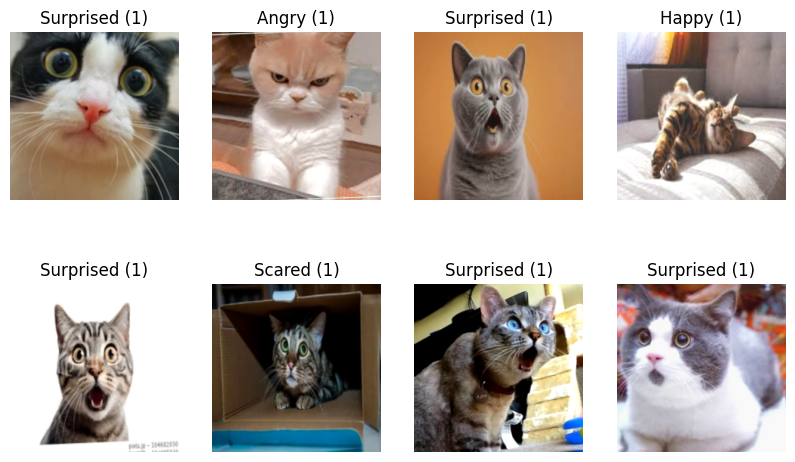

In [12]:
def show_batch(images, labels):
    images = images.permute(0, 2, 3, 1)
    images = images * torch.tensor([0.229, 0.224, 0.225]) + \
             torch.tensor([0.485, 0.456, 0.406])
    images = images.numpy()

    plt.figure(figsize=(10, 6))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(np.clip(images[i], 0, 1))
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()

images, labels = next(iter(train_loader))
show_batch(images, labels)

In [13]:
import torch
import torch.nn as nn
import torchvision.models as models

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [15]:
model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 44.7M/44.7M [00:00<00:00, 178MB/s]


In [16]:
for param in model.parameters():
    param.requires_grad = False


In [17]:
num_classes = 7  # Angry, Disgusted, Happy, Normal, Sad, Scared, Surprised

in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)


In [18]:
model = model.to(device)


In [19]:
x = torch.randn(1, 3, 224, 224).to(device)
y = model(x)
print("Output shape:", y.shape)


Output shape: torch.Size([1, 7])


In [20]:
from collections import Counter

targets = [label for _, label in train_dataset.samples]
class_count = Counter(targets)

num_classes = len(class_count)

class_weights = torch.tensor(
    [1.0 / class_count[i] for i in range(num_classes)],
    dtype=torch.float
)

class_weights = class_weights / class_weights.sum()
class_weights = class_weights.to(device)

print("Class weights:", class_weights)


Class weights: tensor([0.1432, 0.1643, 0.1643, 0.1355, 0.1591, 0.1269, 0.1066],
       device='cuda:0')


In [21]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [22]:
optimizer = torch.optim.Adam(
    model.fc.parameters(),
    lr=1e-3
)


In [23]:
trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad
)

total_params = sum(p.numel() for p in model.parameters())

print(f"Trainable params: {trainable_params}")
print(f"Total params: {total_params}")

Trainable params: 3591
Total params: 11180103


In [24]:
EPOCHS = 30
PATIENCE = 5          # early stopping patience
best_val_loss = float("inf")
patience_counter = 0

In [25]:
def accuracy_from_logits(logits, labels):
    preds = torch.argmax(logits, dim=1)
    correct = (preds == labels).sum().item()
    return correct / labels.size(0)


In [26]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    print(f"\nEpoch [{epoch+1}/{EPOCHS}]")
    print("-" * 30)

    # =====================
    # 🔥 Training Phase
    # =====================
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += accuracy_from_logits(outputs, labels)

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = running_acc / len(train_loader)

    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)

    # =====================
    # 🧪 Validation Phase
    # =====================
    model.eval()
    running_loss = 0.0
    running_acc = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            running_acc += accuracy_from_logits(outputs, labels)

    epoch_val_loss = running_loss / len(val_loader)
    epoch_val_acc = running_acc / len(val_loader)

    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)

    # =====================
    # 📈 Logging
    # =====================
    print(f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f}")
    print(f"Val   Loss: {epoch_val_loss:.4f} | Val   Acc: {epoch_val_acc:.4f}")

    # =====================
    # ⏹️ Early Stopping
    # =====================
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0

        torch.save(model.state_dict(), "best_cat_emotion_model.pth")
        print("✅ Best model saved")

    else:
        patience_counter += 1
        print(f"⚠️ No improvement ({patience_counter}/{PATIENCE})")

        if patience_counter >= PATIENCE:
            print("⛔ Early stopping triggered")
            break



Epoch [1/30]
------------------------------
Train Loss: 1.9984 | Train Acc: 0.2155
Val   Loss: 1.9100 | Val   Acc: 0.2247
✅ Best model saved

Epoch [2/30]
------------------------------
Train Loss: 1.7049 | Train Acc: 0.3678
Val   Loss: 1.8346 | Val   Acc: 0.2948
✅ Best model saved

Epoch [3/30]
------------------------------
Train Loss: 1.5154 | Train Acc: 0.4941
Val   Loss: 1.6151 | Val   Acc: 0.4015
✅ Best model saved

Epoch [4/30]
------------------------------
Train Loss: 1.4149 | Train Acc: 0.5319
Val   Loss: 1.5654 | Val   Acc: 0.4426
✅ Best model saved

Epoch [5/30]
------------------------------
Train Loss: 1.3242 | Train Acc: 0.5586
Val   Loss: 1.3995 | Val   Acc: 0.4949
✅ Best model saved

Epoch [6/30]
------------------------------
Train Loss: 1.2652 | Train Acc: 0.5885
Val   Loss: 1.3590 | Val   Acc: 0.4760
✅ Best model saved

Epoch [7/30]
------------------------------
Train Loss: 1.1896 | Train Acc: 0.6393
Val   Loss: 1.3437 | Val   Acc: 0.5221
✅ Best model saved

Epoch

In [27]:
model.load_state_dict(torch.load("best_cat_emotion_model.pth"))
print("Best model loaded successfully")


Best model loaded successfully


In [28]:
import numpy as np
import torch
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns


In [29]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


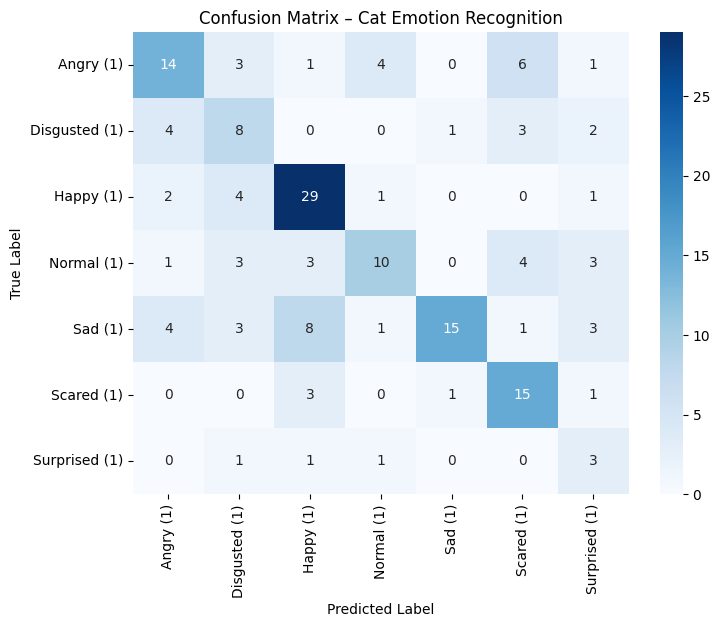

In [30]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Cat Emotion Recognition")
plt.show()


In [31]:
print(
    classification_report(
        all_labels,
        all_preds,
        target_names=class_names,
        digits=4
    )
)


               precision    recall  f1-score   support

    Angry (1)     0.5600    0.4828    0.5185        29
Disgusted (1)     0.3636    0.4444    0.4000        18
    Happy (1)     0.6444    0.7838    0.7073        37
   Normal (1)     0.5882    0.4167    0.4878        24
      Sad (1)     0.8824    0.4286    0.5769        35
   Scared (1)     0.5172    0.7500    0.6122        20
Surprised (1)     0.2143    0.5000    0.3000         6

     accuracy                         0.5562       169
    macro avg     0.5386    0.5437    0.5147       169
 weighted avg     0.6110    0.5562    0.5583       169



In [32]:
macro_f1 = f1_score(all_labels, all_preds, average="macro")
print("Macro F1-score:", round(macro_f1, 4))


Macro F1-score: 0.5147


In [33]:
# Freeze everything first (safety)
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last ResNet block
for param in model.layer4.parameters():
    param.requires_grad = True

# Also keep classifier trainable
for param in model.fc.parameters():
    param.requires_grad = True


In [34]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())

print(f"Trainable params: {trainable_params}")
print(f"Total params: {total_params}")

Trainable params: 8397319
Total params: 11180103


In [35]:
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4   # 🔴 LOWER than before
)

In [36]:
EPOCHS = 20          # fewer epochs
PATIENCE = 5
best_val_loss = float("inf")
patience_counter = 0


In [37]:
for epoch in range(EPOCHS):
    print(f"\nFine-tune Epoch [{epoch+1}/{EPOCHS}]")
    print("-" * 35)

    # 🔥 Training
    model.train()
    train_loss, train_acc = 0.0, 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += (outputs.argmax(1) == labels).float().mean().item()

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    # 🧪 Validation
    model.eval()
    val_loss, val_acc = 0.0, 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_acc += (outputs.argmax(1) == labels).float().mean().item()

    val_loss /= len(val_loader)
    val_acc /= len(val_loader)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    # ⏹️ Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_finetuned_model.pth")
        print("✅ Best fine-tuned model saved")
    else:
        patience_counter += 1
        print(f"⚠️ No improvement ({patience_counter}/{PATIENCE})")
        if patience_counter >= PATIENCE:
            print("⛔ Early stopping triggered")
            break



Fine-tune Epoch [1/20]
-----------------------------------
Train Loss: 0.9020 | Train Acc: 0.7135
Val   Loss: 1.1744 | Val   Acc: 0.5492
✅ Best fine-tuned model saved

Fine-tune Epoch [2/20]
-----------------------------------
Train Loss: 0.3642 | Train Acc: 0.9160
Val   Loss: 1.0841 | Val   Acc: 0.5846
✅ Best fine-tuned model saved

Fine-tune Epoch [3/20]
-----------------------------------
Train Loss: 0.2071 | Train Acc: 0.9570
Val   Loss: 1.0857 | Val   Acc: 0.6130
⚠️ No improvement (1/5)

Fine-tune Epoch [4/20]
-----------------------------------
Train Loss: 0.1476 | Train Acc: 0.9707
Val   Loss: 1.1392 | Val   Acc: 0.5859
⚠️ No improvement (2/5)

Fine-tune Epoch [5/20]
-----------------------------------
Train Loss: 0.1119 | Train Acc: 0.9772
Val   Loss: 1.1354 | Val   Acc: 0.6402
⚠️ No improvement (3/5)

Fine-tune Epoch [6/20]
-----------------------------------
Train Loss: 0.1033 | Train Acc: 0.9746
Val   Loss: 1.1148 | Val   Acc: 0.6515
⚠️ No improvement (4/5)

Fine-tune Epoch

In [38]:
model.load_state_dict(torch.load("best_finetuned_model.pth"))
print("Best fine-tuned model loaded")

Best fine-tuned model loaded


In [39]:
model.load_state_dict(torch.load("best_finetuned_model.pth"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [40]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [41]:
import numpy as np
import torch
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns


In [42]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


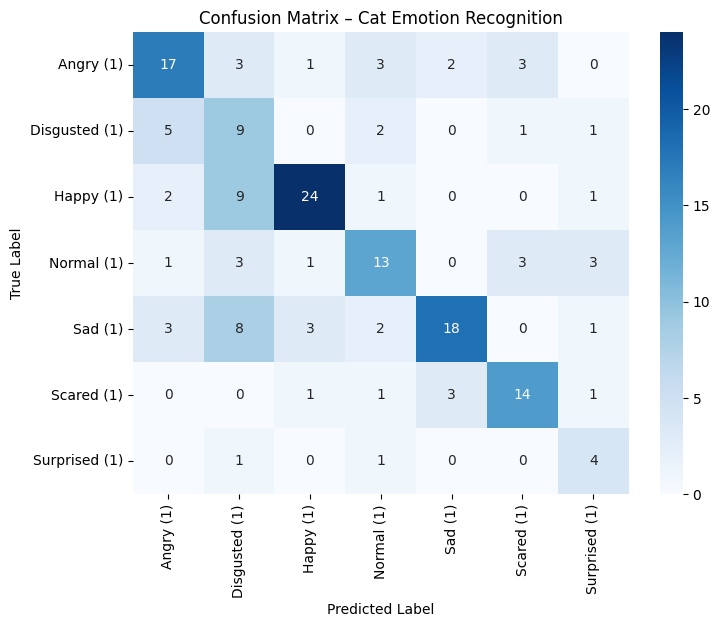

In [43]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Cat Emotion Recognition")
plt.show()


In [44]:
print(
    classification_report(
        all_labels,
        all_preds,
        target_names=class_names,
        digits=4
    )
)

               precision    recall  f1-score   support

    Angry (1)     0.6071    0.5862    0.5965        29
Disgusted (1)     0.2727    0.5000    0.3529        18
    Happy (1)     0.8000    0.6486    0.7164        37
   Normal (1)     0.5652    0.5417    0.5532        24
      Sad (1)     0.7826    0.5143    0.6207        35
   Scared (1)     0.6667    0.7000    0.6829        20
Surprised (1)     0.3636    0.6667    0.4706         6

     accuracy                         0.5858       169
    macro avg     0.5797    0.5939    0.5705       169
 weighted avg     0.6425    0.5858    0.6014       169



In [45]:
macro_f1 = f1_score(all_labels, all_preds, average="macro")
print("Macro F1-score:", round(macro_f1, 4))


Macro F1-score: 0.5705


Saving Beverly-Hills-MI-Scared-Cat.jpg to Beverly-Hills-MI-Scared-Cat.jpg


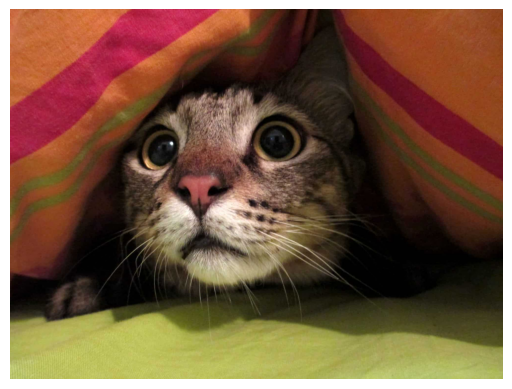

Predicted Emotion: Scared
Confidence: 0.71


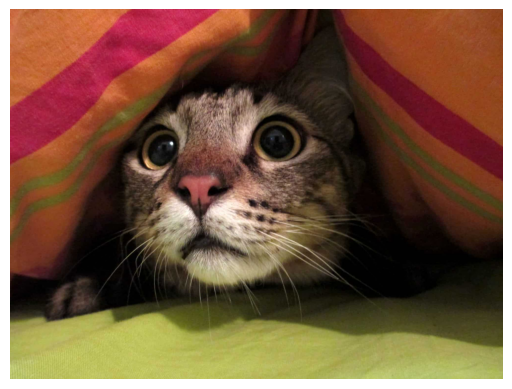

Predicted Emotion: Scared
Confidence: 0.71


In [50]:
from google.colab import files

uploaded = files.upload()   # choose a cat image

class_names = [
    "Angry",
    "Disgusted",
    "Happy",
    "Normal",
    "Sad",
    "Scared",
    "Surprised"
]
from torchvision import transforms
from PIL import Image

infer_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 7)

model.load_state_dict(
    torch.load("/content/best_finetuned_model.pth", map_location=device)
)

model = model.to(device)
model.eval()
import matplotlib.pyplot as plt

# Get uploaded file name
image_path = list(uploaded.keys())[0]

# Load image
image = Image.open(image_path).convert("RGB")

# Show image
plt.imshow(image)
plt.axis("off")
plt.show()

# Preprocess
image_tensor = infer_transform(image).unsqueeze(0).to(device)

# Prediction
with torch.no_grad():
    outputs = model(image_tensor)
    probs = torch.softmax(outputs, dim=1)
    pred_idx = torch.argmax(probs, dim=1).item()

predicted_emotion = class_names[pred_idx]
confidence = probs[0][pred_idx].item()

print(f"Predicted Emotion: {predicted_emotion}")
print(f"Confidence: {confidence:.2f}")
import matplotlib.pyplot as plt

# Get uploaded file name
image_path = list(uploaded.keys())[0]

# Load image
image = Image.open(image_path).convert("RGB")

# Show image
plt.imshow(image)
plt.axis("off")
plt.show()

# Preprocess
image_tensor = infer_transform(image).unsqueeze(0).to(device)

# Prediction
with torch.no_grad():
    outputs = model(image_tensor)
    probs = torch.softmax(outputs, dim=1)
    pred_idx = torch.argmax(probs, dim=1).item()

predicted_emotion = class_names[pred_idx]
confidence = probs[0][pred_idx].item()

print(f"Predicted Emotion: {predicted_emotion}")
print(f"Confidence: {confidence:.2f}")